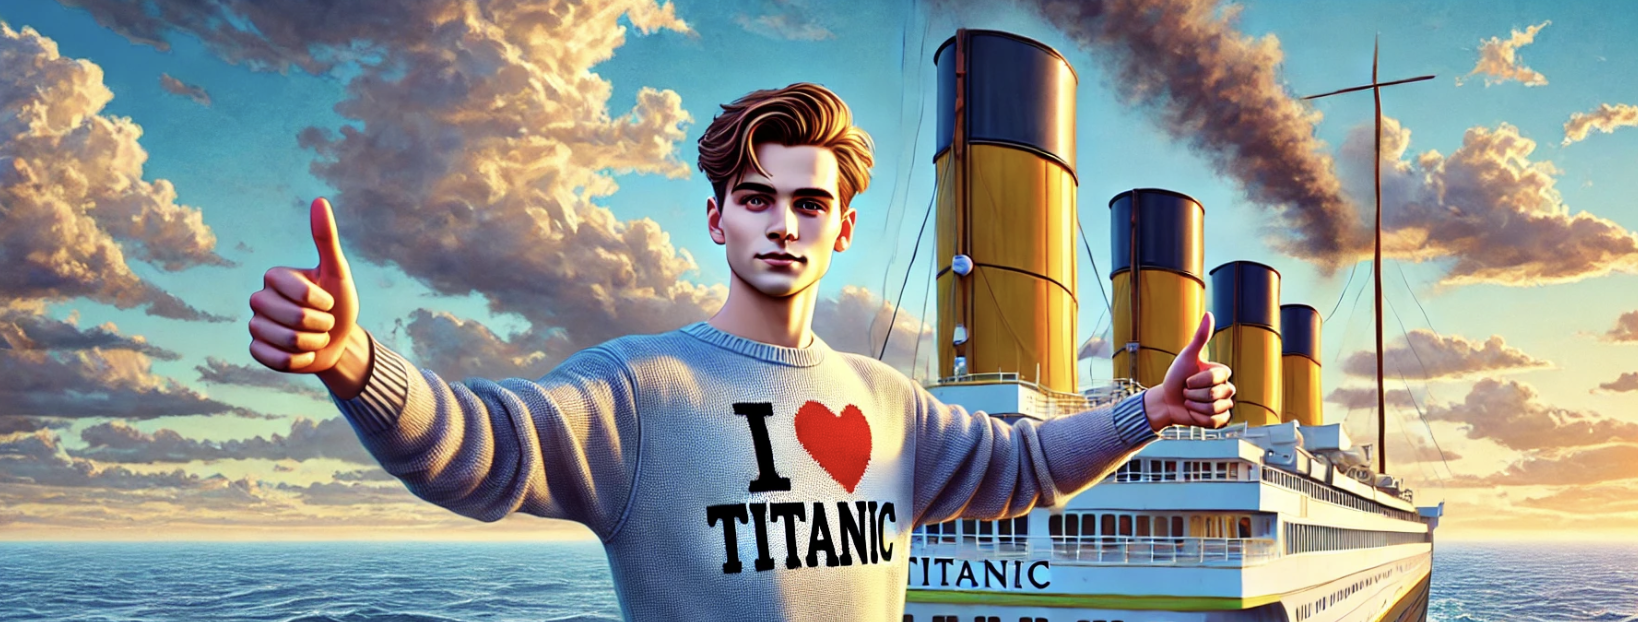

Egy barátod nagy Titanic rajongó, és izgatottan mesélte, hogy indul egy olyan program, ahol egy az eredetihez nagyon hasonlító hajóval bejárják a Titanic eredeti útvonalát. Bár ő lelkes, te aggódsz, és szeretnéd kideríteni, mi lett volna a barátod sorsa, ha az eredeti Titanicon utazott volna. Szerencsére elérhető egy adatbázis az eredeti utasokról, így építesz egy egyszerű AI modellt, amelynek segítségével megjósolhatod, túlélte volna-e az utazást.

Azonban nem elég, ha csak megtudod a végeredményt – szeretnéd megérteni, hogy a modelled szerint melyik feature-ök voltak a legfontosabbak a barátod túlélési esélyeinek meghatározásában. Ehhez SHAP analízist végzel, hogy kiderítsd, melyik feature-nek volt a legnagyobb hatása a predikcióra. Így pontosabb képet kapsz arról, miért hozta a modell azt a döntést és talán segíthet eldönteni, hogy lebeszéld-e a barátodat erről az útról.

A barátod 22 éves férfi, aki első osztályon utazna, és egy 50 fontos jegyet váltott. A családjában senki mást nem érdekel az utazás, így egyedül menne.

Melyik feature befolyásolja a modell döntését a legnagyobb mértékben? Válaszodat a következő formában várjuk, a SHAP értékeket 4 tizedesre kerekítve: `<feature_name>:<shap_value>`

In [1]:
%%capture
!pip install shap==0.46.0 joblib

# Betanított model, scaler és tanítóadat letöltése
!gdown 1bmezxkyz2QnsNl8Vl0U7DlCyCiP_80HO
!gdown 1IOq5DTXznEkz1V5ejPUkUOXCEZuNaAQ_
!gdown 14wooMZmQej0AbtHFTIyb60kYqwFEOVQb


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import numpy as np
import shap

# Feature lista: ezekre a feature-ökre lesz szökséged a prediktáláshoz, vigyázz: a sorrend is számít.
features = ['Pclass', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']


'''
Pclass : int - (proxy for socio-economic status (SES) 1st = Upper / 2nd = Middle / 3rd = Lower)
Sex : int - {'male': 0, 'female': 1}
Age : int
Siblings/Spouses Aboard : int
Parents/Children Aboard : int
Fare : float - Fare paid in £s
'''

/home/ranuon/miniconda3/envs/apollo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


"\nPclass : int - (proxy for socio-economic status (SES) 1st = Upper / 2nd = Middle / 3rd = Lower)\nSex : int - {'male': 0, 'female': 1}\nAge : int\nSiblings/Spouses Aboard : int\nParents/Children Aboard : int\nFare : float - Fare paid in £s\n"

In [5]:
# Betanított model, scaler és tanítóadat betöltése
model = tf.keras.models.load_model('titanic_model.keras')
scaler = load('titanic_std_scaler.bin')
background_data = np.load('titanic_train_data.npy')

W0000 00:00:1732024681.097065   71142 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/ranuon/miniconda3/envs/apollo/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
passenger_data = {
    'Pclass': [1],
    'Sex': [0],
    'Age': [22],
    'Siblings/Spouses Aboard': [0],
    'Parents/Children Aboard': [0],
    'Fare': [50]
}

passenger_df = pd.DataFrame(passenger_data)
passenger_scaled = scaler.transform(passenger_df)
prediction = model.predict(passenger_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [7]:
import shap

explainer = shap.DeepExplainer(model, background_data)
shap_values = explainer.shap_values(passenger_scaled)
shap.initjs()

shap.force_plot(explainer.expected_value[0].numpy(), shap_values.squeeze(), passenger_df.iloc[0], feature_names=features)

/home/ranuon/miniconda3/envs/apollo/lib/python3.11/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/home/ranuon/miniconda3/envs/apollo/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: input_layer. Received: the structure of inputs=['*']
  warnings.warn(


In [8]:
shap_values = np.round(shap_values,4)
for feature_name, shap_value in zip(features, shap_values.squeeze()):
    print(f"{feature_name}: {shap_value:.4f}")

Pclass: 0.2601
Sex: -0.2675
Age: 0.0459
Siblings/Spouses Aboard: 0.0311
Parents/Children Aboard: -0.0098
Fare: 0.0774


In [9]:
features[np.argmax(np.abs(shap_values.squeeze()))]

'Sex'